In [1]:
import numpy as np
import math
from skimage.transform import resize
import scipy.ndimage
import matplotlib.pyplot as plt

# Downsample using order 8 Chebyshev type I filter
def downsample(data):
    return scipy.signal.decimate(data, 6, axis = 0)

def prepare_data(mat):
    # Left footstep
    dataL = mat['dataL']
    # Right footstep
    dataR = mat['dataR']  
    return (dataL, dataR)

def calGRF(data):
    return np.add.accumulate(data)

def process_foot(data):
    Tmax = 1600
    data = data[:Tmax]
    grf = calGRF(data)
    s_avg = data.mean(axis = 1)
    s_upper = np.max(data, axis = 1)
    s_lower = np.min(data, axis = 1)
    grf_t = grf.mean(axis = 1)
    #s_range = s_upper - s_lower
    #s_std = np.std(data, axis = 1)
    #s_grad = np.gradient(s_avg)

    processed = np.append(s_avg, [
        grf_t,
        s_upper,
        s_lower,
        #s_range,
        #s_std,
        #s_grad
    ])
        
    return downsample(processed)

def process_matlab(mat):
    dataL, dataR = prepare_data(mat)
    footL, footR = process_foot(dataL), process_foot(dataR)
    #processed = np.append(footL, [footR, footL - footR])
    processed = np.append(footL, footR)
    return processed


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import scipy.io
import scipy.signal

In [3]:
index_files_path = 'SFootBD/IndexFiles/'
data_files_path = 'SFootBD/SFootBD/'

train_list_file = index_files_path + 'LstTrain'
imposter_list_file = index_files_path + 'LstImp'
test_evaluation_list_file = index_files_path + 'LstTestEvaluation'
test_validation_list_file = index_files_path + 'LstTestValidation'

In [4]:
def load_features(filename):
    mat_file = os.path.join(data_files_path, filename + '.mat')
    mat = scipy.io.loadmat(mat_file)
    return process_matlab(mat)

def load_data_file(index_file):
    return pd.read_csv(index_file, sep = ' ', header = None)

def load_dataset(data_list, clients):    
    X = []
    y = []
    
    for item in data_list.itertuples():
        X_item = load_features(item[2])
        y_item = item[1]
        
        matches = np.where(clients == y_item)[0]
        
        X.append(X_item)
        # clients.shape[0] becomes imposter class
        y.append(matches[0] if matches.shape[0] != 0 else clients.shape[0])
        
    return np.array(X), np.array(y)

In [5]:
train_index = load_data_file(train_list_file)

In [6]:
np.unique(train_index[0], return_counts=True)

(array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  33,  34,  35,  37,
         38,  40,  41,  43,  45,  47,  54,  65,  66,  70,  71,  72,  73,
         74,  76,  94,  95, 124, 126, 132, 134, 135, 136, 137, 155, 160,
        164], dtype=int64),
 array([40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40], dtype=int64))

In [7]:
clients = np.unique(train_index[0])

X_train, y_train = load_dataset(train_index, clients)

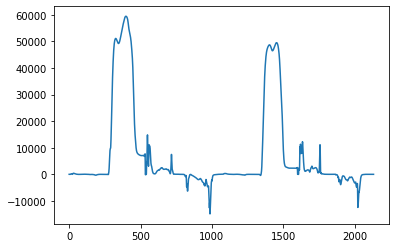

In [8]:
plt.plot(X_train[0])

In [9]:
imposter_index = load_data_file(imposter_list_file)

In [10]:
imposter_index.shape

(763, 2)

In [11]:
X_imposter, y_imposter = load_dataset(imposter_index, clients)

X_train = np.append(X_train, X_imposter, axis = 0)
y_train = np.append(y_train, y_imposter, axis = 0)

In [12]:
val_index = load_data_file(test_validation_list_file)

In [13]:
np.unique(np.isin(val_index[0], clients), return_counts=True)

(array([False,  True]), array([ 380, 6697], dtype=int64))

In [14]:
np.unique(val_index[0][np.isin(val_index[0], clients)], return_counts=True)

(array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  33,  34,  35,  37,
         38,  40,  41,  43,  45,  47,  54,  65,  66,  70,  71,  72,  73,
         74,  76,  94,  95, 124, 126, 132, 134, 135, 136, 137, 155, 160,
        164], dtype=int64),
 array([440, 499, 153, 131, 230,  50,  25,  36, 395, 339,  59, 178,  40,
         18, 171, 272,  15, 180, 177,  11,  22, 106,  84,  16,  10,  52,
        224,  50, 646, 557,  19,  15,  35, 614, 591,  41,  43, 112,  31,
         10], dtype=int64))

In [15]:
# Validation set is too big
#X_val, y_val = load_dataset(val_index, clients)

#X_train = np.append(X_train, X_val, axis = 0)
#y_train = np.append(y_train, y_val, axis = 0)

In [16]:
eval_index = load_data_file(test_evaluation_list_file)

In [17]:
np.unique(np.isin(eval_index[0], clients), return_counts=True)

(array([False,  True]), array([350, 200], dtype=int64))

In [18]:
X_test, y_test = load_dataset(eval_index, clients)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.linear_model import SGDClassifier

model = Pipeline([
    ("std_scaler", StandardScaler()),
    #("model", OneVsRestClassifier(SVC(kernel='rbf')))
    ("model", SVC(kernel='rbf', C=7, gamma=1))
    #("model", SGDClassifier())
])

In [20]:
#from sklearn.utils import shuffle
#X_train, y_train = shuffle(X_train, y_train)

In [21]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 SVC(C=7, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [22]:
y_pred = model.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6363636363636364

In [24]:
imposter_class = clients.shape[0]

fp = np.logical_and(y_pred != imposter_class, y_pred != y_test)
fp = np.where(fp)[0].shape[0]

fn = np.logical_and(y_pred == imposter_class, y_test != imposter_class)
fn = np.where(fn)[0].shape[0]

cnt = y_test.shape[0]
far = fp / cnt
frr = fn / cnt

In [25]:
#import bob.measure #doesn't work on windows

In [26]:
print (far, frr)

0.0 0.36363636363636365


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [0.01, 1, 100], 'gamma': [100, 1, 0.1, 0.001], 'kernel': ['rbf']},
]

clf = GridSearchCV(SVC(), param_grid)
clf.fit(X_train, y_train)

In [15]:
clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [16]:
clf.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'